In [40]:
import queue
from experiment_information import *
from experiments.sweep_generalization_error import *
from data import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as np
import numpy as np
import logging
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_erm = dbHandler.get_erms()
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()
print("Current code version, ", __version__)

Current code version,  25


In [42]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "13"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(2)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,d,erm_methods,completed
53,3739b005-e85b-46d0-93a2-7b4a0c7fdc3e,Default Experiment,4038.399501,25,2023-04-11 20:09:57,1,10,"[0.1, 0.8, 1.5000000000000002, 2.2, 2.90000000...","[0.0, 0.02, 0.05, 0.07, 0.09]",[1e-05],[2],500,"[""sklearn""]",1
52,c6c3557b-5dd3-4261-98de-7c438b21fc31,Default Experiment,2173.058411,25,2023-04-11 19:30:31,1,10,"[0.1, 0.8, 1.5000000000000002, 2.2, 2.90000000...","[0.0, 0.001, 0.01, 0.02]",[1e-05],[2],500,"[""sklearn""]",1


In [43]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[0]["experiment_id"]
print(experiment_id)

# This guy was interesting in version 25 for the q- state evolution adaptation
# a2a3016c-8264-4599-ac8f-b457da2790ba

3739b005-e85b-46d0-93a2-7b4a0c7fdc3e


In [44]:
state_evolution

generalization_error_state_evolution  \
alpha epsilon tau lam                                             
0.1   0.000   2.0 0.00001                              0.484507   
      0.001   2.0 0.00001                              0.484510   
      0.010   2.0 0.00001                              0.484535   
      0.020   2.0 0.00001                              0.484553   
0.8   0.000   2.0 0.00001                              0.464972   
      0.001   2.0 0.00001                              0.464997   
      0.010   2.0 0.00001                              0.465160   
      0.020   2.0 0.00001                              0.465252   
1.5   0.000   2.0 0.00001                              0.458792   
      0.001   2.0 0.00001                              0.458802   
      0.010   2.0 0.00001                              0.458844   
      0.020   2.0 0.00001                              0.458836   
2.9   0.000   2.0 0.00001                              0.435352   
      0.001   2.0 0.00001                              0.435328   
      0.010   2.0 0.00001                              0.435112   
      0.020   2.0 0.00001                              0.434878   
2.2   0.020   2.0 0.00001                              0.451630   
3.6   0.000   2.0 0.00001                              0.425765   
      0.001   2.0 0.00001                              0.425748   
      0.010   2.0 0.00001                              0.425597   
      0.020   2.0 0.00001                              0.425432   
4.3   0.000   2.0 0.00001                              0.418636   
      0.001   2.0 0.00001                              0.418622   
      0.010   2.0 0.00001                              0.418502   
      0.020   2.0 0.00001                              0.418372   
5.0   0.000   2.0 0.00001                              0.412957   
      0.001   2.0 0.00001                              0.412946   
      0.010   2.0 0.00001                              0.412846   
2.2   0.010   2.0 0.00001                              0.452628   
5.0   0.020   2.0 0.00001                              0.412737   
2.2   0.001   2.0 0.00001                              0.453847   
      0.000   2.0 0.00001                              0.454011   

                           sigma_state_evolution  q_state_evolution  \
alpha epsilon tau lam                                                 
0.1   0.000   2.0 0.00001           91074.826325           9.193269   
      0.001   2.0 0.00001           90893.257784           9.744473   
      0.010   2.0 0.00001           88742.378649          15.404450   
      0.020   2.0 0.00001           83959.449681          22.796714   
0.8   0.000   2.0 0.00001           43899.585585         135.528716   
      0.001   2.0 0.00001           43010.455583         141.256255   
      0.010   2.0 0.00001           34474.801261         189.474363   
      0.020   2.0 0.00001           24988.935533         227.463769   
1.5   0.000   2.0 0.00001           17281.746437         716.879292   
      0.001   2.0 0.00001           16325.774694         731.252510   
      0.010   2.0 0.00001            9455.700331         798.599858   
      0.020   2.0 0.00001            5248.232590         788.200666   
2.9   0.000   2.0 0.00001               4.981063          11.594901   
      0.001   2.0 0.00001               4.967625          11.568231   
      0.010   2.0 0.00001               4.850105          11.334952   
      0.020   2.0 0.00001               4.726343          11.089203   
2.2   0.020   2.0 0.00001              33.431684         233.600311   
3.6   0.000   2.0 0.00001               2.816730           5.819280   
      0.001   2.0 0.00001               2.811415           5.811065   
      0.010   2.0 0.00001               2.764412           5.738085   
      0.020   2.0 0.00001               2.713881           5.658937   
4.3   0.000   2.0 0.00001               1.973336           3.984608   
      0.001   2.0 0.00001               1.97

In [45]:
import struct
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# round alphas to 2 decimals
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: round(x,2))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
# gd = erm[erm["chosen_minimizer"] == "gd"]
# gd = erm[erm["chosen_minimizer"] == "L-BFGS-B"]
# gd = erm[erm["chosen_minimizer"] == "logistic"]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# round alphas to 2 decimals
gd["alpha"] = gd["alpha"].apply(lambda x: round(x,2))
# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam"])
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam"])
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","m","cosb","training_error"]]
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error","d"]]
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm','m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_error_state_evolution","training_error_erm","d_erm"]]
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3]).agg([np.mean,np.std])
# display all columns
pd.set_option('display.max_columns', None)
df

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_28044/1773663751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: round(x,2))


generalization_error_state_evolution       \
                                                          mean  std   
alpha epsilon tau lam                                                 
0.1   0.00    2.0 0.00001                             0.484507  0.0   
      0.02    2.0 0.00001                             0.484553  0.0   
      0.05    2.0 0.00001                             0.484573  0.0   
      0.07    2.0 0.00001                             0.484578  0.0   
      0.09    2.0 0.00001                             0.484581  0.0   
0.8   0.00    2.0 0.00001                             0.464972  0.0   
      0.02    2.0 0.00001                             0.465252  0.0   
      0.05    2.0 0.00001                             0.465291  0.0   
      0.07    2.0 0.00001                             0.465269  0.0   
      0.09    2.0 0.00001                             0.465244  0.0   
1.5   0.00    2.0 0.00001                             0.458792  0.0   
      0.02    2.0 0.00001                             0.458836  0.0   
      0.05    2.0 0.00001                             0.458765  0.0   
      0.07    2.0 0.00001                             0.458737  0.0   
      0.09    2.0 0.00001                             0.458726  0.0   
2.2   0.00    2.0 0.00001                             0.454011  0.0   
      0.02    2.0 0.00001                             0.451630  0.0   
      0.05    2.0 0.00001                             0.449532  0.0   
      0.07    2.0 0.00001                             0.448480  0.0   
      0.09    2.0 0.00001                             0.447576  0.0   
2.9   0.00    2.0 0.00001                             0.435352  0.0   
      0.02    2.0 0.00001                             0.434878  0.0   
      0.05    2.0 0.00001                             0.434210  0.0   
      0.07    2.0 0.00001                             0.433792  0.0   
      0.09    2.0 0.00001                             0.433391  0.0   
3.6   0.00    2.0 0.00001                             0.425765  0.0   
      0.02    2.0 0.00001                             0.425432  0.0   
      0.05    2.0 0.00001                             0.424957  0.0   
      0.07    2.0 0.00001                             0.424655  0.0   
      0.09    2.0 0.00001                             0.424364  0.0   
4.3   0.00    2.0 0.00001                             0.418636  0.0   
      0.02    2.0 0.00001                             0.418372  0.0   
      0.05    2.0 0.00001                             0.417993  0.0   
      0.07    2.0 0.00001                             0.417752  0.0   
      0.09    2.0 0.00001                             0.417520  0.0   
5.0   0.00    2.0 0.00001                             0.412957  0.0   
      0.02    2.0 0.00001                             0.412737  0.0   
      0.05    2.0 0.00001                             0.412421  0.0   
      0.07    2.0 0.00001                             0.412220  0.0   
      0.09    2.0 0.00001                             0.412027  0.0   

                          generalization_error_erm_erm            \
                                                  mean       std   
alpha epsilon tau lam                                              
0.1   0.00    2.0 0.00001                     0.481015  0.006647   
      0.02    2.0 0.00001                     0.483175  0.007351   
      0.05    2.0 0.00001                     0.483746  0.006516   
      0.07    2.0 0.00001                     0.485066  0.007286   
      0.09    2.0 0.00001                     0.485121  0.006568   
0.8   0.00    2.0 0.00001                     0.465173  0.005186   
      0.02    2.0 0.00001                     0.459513  0.007456   
      0.05    2.0 0.00001                     0.464021  0.006184   
      0.07    2.0 0.00001                     0.464959  0.004479   
      0.09    2.0 0.00001                     0.464583  0.004711   
1.5   0.00    2.0 0.00001                     0.459869  0.006481   
      0.02    2.0 0.

In [46]:
def create_plot(df, error_name, state_evolution_name, gd_name):
    df2 = df.reset_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2['epsilon'].unique()))

    d = df2['d_erm']["mean"][0]

    for tau in df2['tau'].unique():
        for lam in df2['lam'].unique():
            # Filter the dataframe for the current values of tau and lam
            data = df2[(df2['tau'] == tau) & (df2['lam'] == lam)]
            
            for i, epsilon in enumerate(data['epsilon'].unique()):
                # Filter the dataframe for the current value of epsilon
                epsilon_subset = data[data['epsilon'] == epsilon]

                # Plot the state_evolution results as a line
                plt.plot(epsilon_subset['alpha'], epsilon_subset[(state_evolution_name, 'mean')], label=f'Epsilon: {epsilon}', color=palette[i])
                
                # Plot the gradient_descent results as points with error bars
                plt.errorbar(epsilon_subset['alpha'], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
            
            # Add labels and title
            plt.xlabel('Alpha')
            plt.ylabel(error_name)
            plt.title(f'{error_name} - Tau: {tau}, Lambda: {lam}, d: {d}')
            # Add a legend
            plt.legend()

            name = f"{error_name}_tau_{tau}_lam_{lam}"
            # Save the plot as svg
            plt.savefig(f"Assets/{name}.svg")

            # Show the plot
            plt.show()

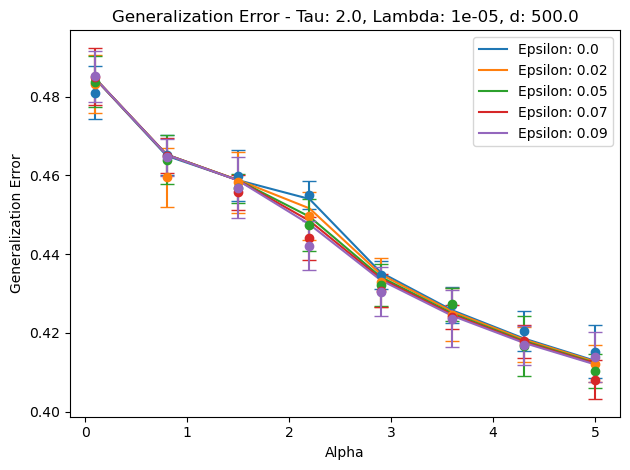

In [47]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm")

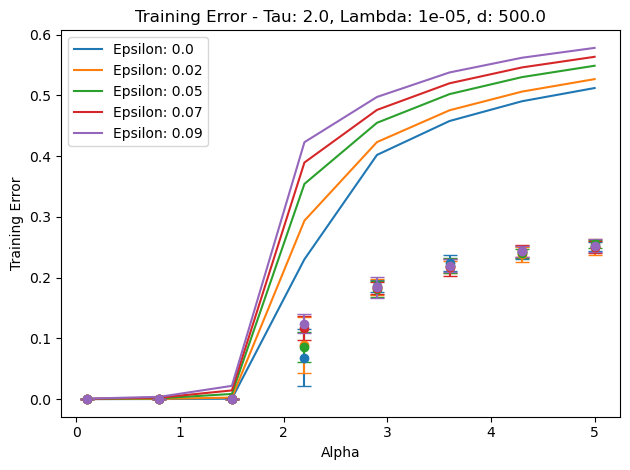

In [48]:
create_plot(df, "Training Error", "training_error_state_evolution", "training_error_erm")

In [49]:
# # Create a SweepExperiment
# experiment = get_default_experiment()
# # use json dump to save the experiment parameters
# with open("sweep_experiment.json","w") as f:
#     # use the NumpyEncoder to encode numpy arrays
#     json.dump(experiment.__dict__,f,cls=NumpyEncoder)